In [1]:
import tensorflow as tf

In [2]:
print(f'Tensorflow Version:{tf.__version__}')

Tensorflow Version:2.3.0


In [3]:
# tf.config.list_physical_devices('GPU')           # 确认运行环境

In [4]:
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob      # 批处理文件路径

In [5]:
all_image_path = glob.glob('D:/deep-learning/2_class/*/*.jpg')

In [6]:
all_image_path[:5]

['D:/deep-learning/2_class\\airplane\\airplane_001.jpg',
 'D:/deep-learning/2_class\\airplane\\airplane_002.jpg',
 'D:/deep-learning/2_class\\airplane\\airplane_003.jpg',
 'D:/deep-learning/2_class\\airplane\\airplane_004.jpg',
 'D:/deep-learning/2_class\\airplane\\airplane_005.jpg']

In [7]:
len(all_image_path)

1400

In [8]:
import random 

In [9]:
random.shuffle(all_image_path)

In [10]:
all_image_path[:5]

['D:/deep-learning/2_class\\airplane\\airplane_002.jpg',
 'D:/deep-learning/2_class\\lake\\lake_614.jpg',
 'D:/deep-learning/2_class\\lake\\lake_341.jpg',
 'D:/deep-learning/2_class\\airplane\\airplane_661.jpg',
 'D:/deep-learning/2_class\\lake\\lake_361.jpg']

In [11]:
label_to_index = {'airplane': 0, 'lake': 1}

In [12]:
index_to_label = dict((i,j) for j, i in label_to_index.items())

使用split获取图片类别

In [13]:
img = all_image_path[100]

In [14]:
img.split('\\')[1]

'lake'

In [15]:
label_to_index.get(img.split('\\')[1])

1

In [16]:
all_labels = [label_to_index.get(img.split('\\')[1]) for img in all_image_path]

In [17]:
all_labels[:5]

[0, 1, 1, 0, 1]

读取图片

In [23]:
def load_img(path):
    img_raw = tf.io.read_file(path)            # 读取图片
    img_tensor = tf.image.decode_jpeg(img_raw, channels=3)                   # 对tensor格式进行解码
    img_tensor = tf.image.resize(img_tensor, [256, 256])                  # 规范图片大小
    img_tensor = tf.cast(img_tensor, tf.float32)                      # 转换数据类型
    img_tensor = img_tensor/255                            # 归一化
    return img_tensor

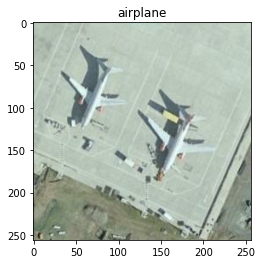

In [24]:
i = random.choice(range(len(all_image_path)))
img_tensor = load_img(all_image_path[i])
label = all_labels[i]
plt.title(index_to_label.get(label))
plt.imshow(img_tensor.numpy())
plt.show()

创建dataset

In [25]:
# img_tensor.shape[0]

In [26]:
img_ds = tf.data.Dataset.from_tensor_slices(all_image_path)
img_ds = img_ds.map(load_img)

In [27]:
img_ds

<MapDataset shapes: (256, 256, 3), types: tf.float32>

In [28]:
label_ds = tf.data.Dataset.from_tensor_slices(all_labels)

In [29]:
label_ds

<TensorSliceDataset shapes: (), types: tf.int32>

## 划分训练集和测试集

合并图片和标签

In [30]:
img_label_ds = tf.data.Dataset.zip((img_ds, label_ds))

In [31]:
img_count = len(all_image_path)
test_count = int(img_count * 0.2)
train_count = img_count - test_count

In [32]:
train_ds = img_label_ds.skip(test_count)
test_ds = img_label_ds.take(test_count)

In [33]:
BATCH_SIZE = 16

In [34]:
train_ds = train_ds.repeat().shuffle(buffer_size=100).batch(BATCH_SIZE)

In [35]:
train_ds

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [36]:
test_ds = test_ds.batch(BATCH_SIZE)

In [37]:
test_ds

<BatchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

## 模型的创建

In [38]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(64, (3, 3), input_shape=(256,256,3),activation='relu',padding='same'))     # 卷积层
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D())        # 池化层
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu',padding='same'))
model.add(tf.keras.layers.Conv2D(256, (3, 3), activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D())
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu',padding='same'))
model.add(tf.keras.layers.Conv2D(512, (3, 3), activation='relu',padding='same'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0

In [40]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc']
)

In [41]:
steps_per_epochs = train_count//BATCH_SIZE
val_step = test_count//BATCH_SIZE

In [42]:
history = model.fit(train_ds, epochs=30,
                   steps_per_epoch = steps_per_epochs,
                   validation_data=test_ds,
                   validation_steps=val_step
)

Epoch 1/30
70/70 [==============================] - 628s 9s/step - loss: 0.6453 - acc: 0.5286 - val_loss: 0.6655 - val_acc: 0.8676
Epoch 2/30
70/70 [==============================] - 637s 9s/step - loss: 0.4630 - acc: 0.8295 - val_loss: 0.3355 - val_acc: 0.9007
Epoch 3/30
70/70 [==============================] - 633s 9s/step - loss: 0.1732 - acc: 0.9509 - val_loss: 0.2341 - val_acc: 0.9338
Epoch 4/30
70/70 [==============================] - 633s 9s/step - loss: 0.1364 - acc: 0.9616 - val_loss: 0.3041 - val_acc: 0.8824
Epoch 5/30
70/70 [==============================] - 620s 9s/step - loss: 0.1497 - acc: 0.9545 - val_loss: 0.1754 - val_acc: 0.9522
Epoch 6/30
70/70 [==============================] - 633s 9s/step - loss: 0.1082 - acc: 0.9616 - val_loss: 0.1948 - val_acc: 0.9485
Epoch 7/30
70/70 [==============================] - 625s 9s/step - loss: 0.1032 - acc: 0.9679 - val_loss: 0.1340 - val_acc: 0.9632
Epoch 8/30
70/70 [==============================] - 626s 9s/step - loss: 0.0968 - a

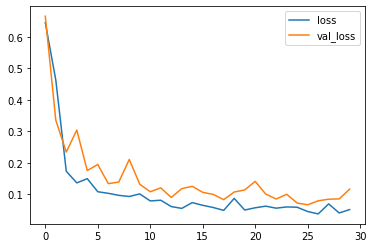

In [43]:
plt.plot(history.epoch, history.history.get('loss'), label='loss')
plt.plot(history.epoch, history.history.get('val_loss'), label='val_loss')
plt.legend()

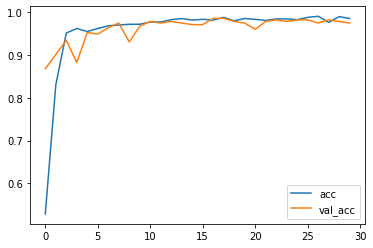

In [44]:
plt.plot(history.epoch, history.history.get('acc'), label='acc')
plt.plot(history.epoch, history.history.get('val_acc'), label='val_acc')
plt.legend()